<a href="https://colab.research.google.com/github/tibebu-sime/fraud-detection/blob/main/creditcard_frauddetection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Attributes Information**

It contains only numerical input variables which are the result of a Principal Component Analysis(PCA) transformation due to confidentiality issues.
1. *Features V1, V2, … V28* are the principal components obtained with PCA.
2. *Time*: contains the seconds elapsed between each transaction and the first transaction in the dataset.
3. *Amount*: the transaction amount
4. *Class*: is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix

In [3]:
filename = '/content/drive/MyDrive/CodingDojo/Projects/creditcard.csv'
df = pd.read_csv(filename)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##**Data Cleaning and Exploratory Data Analysis**

In [ ]:
# Printing quick information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Checking missing values in each column
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no missing values in the dataset.

In [4]:
# Identify duplicate values and mark all the duplicates as true
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
df[df.duplicated(keep=False)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,-0.830603,-1.191774,0.942870,1.372621,-0.037988,-0.208490,0.321883,-0.205951,-0.025225,-0.468427,0.023667,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284190,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,-1.449823,-0.508930,0.600035,-0.627313,1.017499,-0.887384,0.420096,1.856497,1.315099,1.096112,-0.821707,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,-1.449823,-0.508930,0.600035,-0.627313,1.017499,-0.887384,0.420096,1.856497,1.315099,1.096112,-0.821707,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0
284192,172233.0,-2.691642,3.123168,-3.339407,1.017018,-0.293095,-0.167054,-0.745886,2.325616,-1.634651,-1.440241,-0.511918,0.607878,-0.627645,1.023032,-0.888334,0.413444,1.860351,1.316597,1.094512,-0.791037,0.402639,0.259746,-0.086606,-0.097597,0.083693,-0.453584,-1.205466,-0.213020,36.74,0


From the result above, we can see that the dataset contains many duplicate values. So, I'm going to remove the repeated observations except for the first occurrence of each instance. 

In [5]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
df = df.drop_duplicates(keep='first')

In [ ]:
# Check the distribution of the credit card fraud cases 
class_proportion = df['Class'].value_counts()
class_proportion

0    283253
1       473
Name: Class, dtype: int64

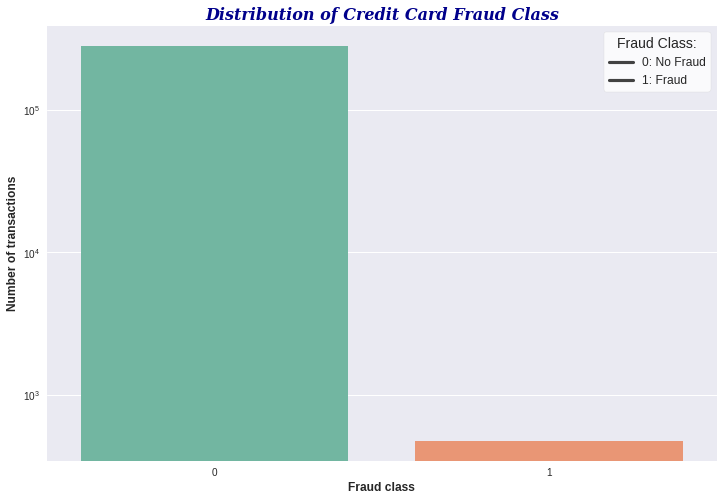

In [ ]:
# Plotting a barchart to see the the distribution of the credit card fraud cases
# https://seaborn.pydata.org/generated/seaborn.barplot.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette
# https://matplotlib.org/stable/api/legend_api.html
# https://matplotlib.org/stable/api/font_manager_api.html#matplotlib.font_manager.FontProperties

plt.style.use('seaborn')
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkBlue'}
font2 = {'weight': 'bold', 'size': 12}
font3 = {'weight': 'normal', 'size': 12}

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(class_proportion.index, class_proportion.values, palette='Set2')
ax.set_title('Distribution of Credit Card Fraud Class', fontdict=font1)
ax.set_xlabel('Fraud class', fontdict=font2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('Number of transactions', fontdict=font2)
ax.set_yscale('log')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels=['0: No Fraud', '1: Fraud'], prop= font3, 
          title ='Fraud Class:', title_fontsize=14,
          frameon=True, facecolor='white')
plt.show()

From the barchart, we can see that the number of legitimate credit card transactions is extremely higher the number of fraudulent transactions. This is obviously expected because fraud detection is one of the problem domains where the class distribution is inherently imbalanced. I would have been surprised if the fraudulent transactions happened to be higher the legitimate ones because it indicates that these banking institutions were facing serious security breaches which could lead to loss of revenue, interruptions in operations and loss of both reputation and customers. Anyways, we need to deal with this huge data imbalance as it can hamper the accuracy of our classification model. 

##**Feature Engineering and Data Modeling**

In [ ]:
# Check the proportion of the fraud cases and identify the imbalance
# https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

df['Class'].value_counts(normalize=True)

0    0.998333
1    0.001667
Name: Class, dtype: float64

From the above result, we can observe that the number of fraudulent transactions is relatively rare. It only makes up about 0.2% of the entire transactions. This is super imbalanced. If we take this proportion as a baseline model, we will get a pretty high accuracy of 99.8% by creating a model which just predicts everything to be 0 whatever input data comes in. But this will fail to capture the minority class, although typically it is the model performance on the minority class which is the most important. 

To summarize, in a dataset with highly imbalanced cases, accuracy score can be misleading because a high accuracy rate is achieved not because our model is any good but simply because the classifier algorithm will always predict the majority class without performing any analysis of the features. 




**Balancing out the dataset with resampling techniques**
>There are many approaches to solve this type of highly imbalanced binary classification problem. The simplest and most widely adopted techniques are undersampling and oversampling. The former involves removing some records from the majority class, while the latter is adding more random copies to the minority class. Both techniques are done until the majority and minority class is balanced out. But I'm going to oversample the minority class using Synthetic Minority Oversampling Technique(SMOTE). This is a more sophisticated resampling technique which introduces small variations into the copies of the minority class observations instead of those exact copies, generating more diverse sythetic samples. The SMOTE class lives in the *imblearn.over_sampling* module of the Python *imbalanced-learn* libray(imported as imblearn), which in fact relies on scikit-learn(imported as sklearn) and is part of scikit-learn-contrib projects. 

In [6]:
# Arrange the dataset into features matrix and target vector
# Drop the 'Time' variable as it does not that much help our analysis
X = df.drop(columns=(['Time', 'Class']))
y = df['Class']

In [7]:
# Make a SMOTE instance, then fit and apply it in one step 
# to create an oversampled version of our dataset.
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

sm = SMOTE(sampling_strategy='auto', random_state=3, k_neighbors=5)
X_oversampled , y_oversampled = sm.fit_resample(X, y)

In [ ]:
# Summarize the fraud class distribution of the new SMOTE-transformed dataset
# https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray

unique_original, counts_original = np.unique(y, return_counts=True)
unique_oversampled, counts_oversampled = np.unique(y_oversampled, return_counts=True)

print('Original fraud class distribution:', dict(zip(unique_original, counts_original)))
print('New transformed fraud class distribution:',dict(zip(unique_oversampled, counts_oversampled)))

Original fraud class distribution: {0: 283253, 1: 473}
New transformed fraud class distribution: {0: 283253, 1: 283253}


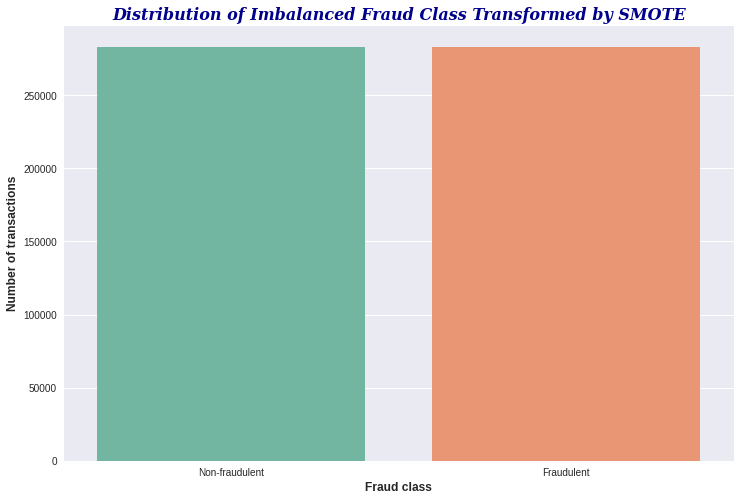

In [ ]:
# Now visualize the SMOTE-transformed target variable
# https://stackoverflow.com/questions/54304913/what-is-major-difference-between-histogram-countplot-and-distplot-in-seaborn-lib
plt.style.use('seaborn')
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkBlue'}
font2 = {'weight': 'bold', 'size': 12}

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y_oversampled, palette='Set2', ax=ax)
ax.set_title('Distribution of Imbalanced Fraud Class Transformed by SMOTE', fontdict=font1)
ax.set_xlabel('Fraud class', fontdict=font2)
ax.set_xticklabels(['Non-fraudulent', 'Fraudulent'])
ax.set_ylabel('Number of transactions', fontdict=font2)
plt.show()

From the class distribution summary and barchart above, we can see the dataset is transformed using the SMOTE and the new class distribution is is balaced, having now with equal samples in the minority class.

**1. Random Forest Classifier (RFC) Model**

In [36]:
# Separate the transformed features matrix and target vector into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=3)

In [37]:
# Instantiate and fit the model
rfc = RandomForestClassifier(n_estimators=150)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
# Model Evalution -classification accuracy
training_rfc_accuracy = rfc.score(X_train, y_train)
testing_rfc_accuracy = rfc.score(X_test, y_test)

print("Training RFC Accuracy:", training_rfc_accuracy)
print("Testing RFC Accuracy:", testing_rfc_accuracy )

Training RFC Accuracy: 1.0
Testing RFC Accuracy: 0.9998658447894823


Earlier I mentioned that accuracy can be a misleading metric to evaluate a model for a dataset with highly imbalanced classes. But in our case, I've managed to beat the baseline model accuracy score(99.80%). From the result above, we can see that the accuracy score I got is about 99.99%, which is higher than the baseline model accuracy score.

Next, I will be using the following four most useful metrics to evaluate the performance of a model for highly imbalanced binary-class datasets:
> 1. Sensitivity (True Positive Rate)
> 2. Specificity (True Negative Rate)
> 3. Precision (Positive Predictive Value)
> 4. Area Under ROC Curve (AUROC)




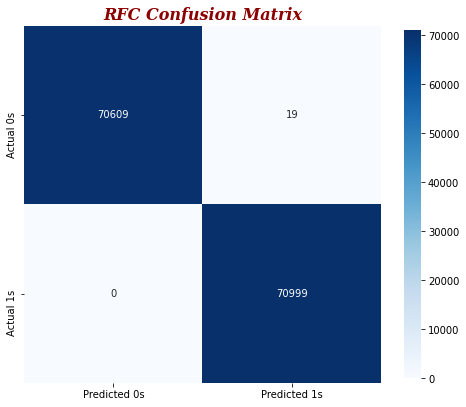

In [42]:
# Plotting the confusion matrix for Random Forest 
fig, ax = plt.subplots(figsize=(8, 8))
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkRed'}
font2 = {'weight': 'bold', 'size': 12}

sns.heatmap(confusion_matrix(y_test, rfc.predict(X_test)), 
            cmap='Blues', 
            square=True,
            annot=True,
            fmt='d',
            cbar_kws={'shrink': 0.8},
            xticklabels=['Predicted 0s', 'Predicted 1s'],
            yticklabels=['Actual 0s', 'Actual 1s'])
ax.set_title('RFC Confusion Matrix', fontdict=font1)
plt.show()

In [ ]:
# Model evaluation - Sensitivity, Specificity and Precision 
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

TN, FP, FN, TP = confusion_matrix(y_test, rfc.predict(X_test)).flatten()
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

sensitivity = TP/(TP + FN)
specificity = TN/(TN + FP)
precision = TP/(TP + FP)
print("\nSensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)

True Negatives: 70610
False Positives: 18
False Negatives: 0
True Positives: 70999

Sensitivity: 1.0
Specificity: 0.9997451435691227
Precision: 0.9997465395609502


From the confusion matrix and the statistics above, we can see that our model is 100% accurate in detecting fraud. This means our model is very highly sensitive, which is in fact what the banking institutions may be more concerned for because a false negative (ignoring the probability of a transaction being fraud when there actually is one) is more dangerous than a false positive. 

Of course, in a credit card fraud detection system, a smart model with good classification accuracy rate should also have significantly less false positives because the errors can cost the banks billions of dollars in lost revenue as customers getting declined in legitimate transactions may get frustrated and then refrain from using that credit card anymore. 

In [ ]:
# Check the predicted probabilities for every observation in the test data subset 
# Note that the default classification threshold is 0.5
testing_probabilities= rfc.predict_proba(X_test)
testing_probabilities

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.99333333, 0.00666667],
       [0.99333333, 0.00666667],
       [0.        , 1.        ]])

As we can see from the above result, the matrix of probabilities being returned indicates the predicted class is equal to 0 or 1. In this matrix, each each row corresponds to a single observation: The first column is the probability of the predicted output being zero(non-fraud), that is 1 - 𝑝(𝑥_test), and the second column is the probability that the output is one(fraud), or 𝑝(𝑥_test).

In [ ]:
# Convert the testing probabilities into a dataframe
testing_probabilities_df = pd.DataFrame(testing_probabilities, columns=['1 - 𝑝(X_test)', '𝑝(X_test)'])
testing_probabilities_df.head()

,1 - 𝑝(X_test),𝑝(X_test)
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


In [ ]:
# Get predictions
rfc.predict(X_test)

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
# Model evaluation -AUC
# Calculate AUC for both training and testing subsets
# Only probabilities being in the positive class is needed for the calculation, that is the second column
training_rfc_AUC = roc_auc_score(y_train, rfc.predict_proba(X_train)[:, 1]) 
testing_rfc_AUC = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])

print("Training RFC AUC:", training_rfc_AUC)
print("Testing RFC AUC:", testing_rfc_AUC)

Training RFC AUC: 1.0
Testing RFC AUC: 0.9999914201114866


**2. Logistic Regression (LGR) Model**

In [40]:
# Separate the transformed features matrix and target vector into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=3)

*Automating hyperparameters*:
>I will use GridSearch to find the Logistic Regression model with the best performing hyperparameter combination. Here, note that we don't have to scale the data again as it were already done during the Principal Component Analysis transformation due confidentiality issues

In [50]:
# define dictionary of hyperparameters
params = {'penalty': ['l1', 'l2'],
          'C': [0.0001, 0.001, 0.01, 10, 50, 100],
          'class_weight': [None, 'balanced']}

In [51]:
# Instantiate Logistic Regression model. N.B: the default solver doesn't support l1 regularization
# Instantiate Grid Search to find the best hyperparameters and fit the model
lgr = LogisticRegression(solver='liblinear')
gs = GridSearchCV(lgr, params, cv = 5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 10, 50, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
gs.best_estimator_

LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
# Model evaluation - accuracy 
training_lgr_accuracy = gs.score(X_train, y_train)
testing_lgr_accuracy = gs.score(X_test, y_test)

print("Training LGR Accuracy:", training_lgr_accuracy)
print("Testing LGR Accuracy:", testing_lgr_accuracy)

Training LGR Accuracy: 0.9586494037125864
Testing LGR Accuracy: 0.9577269870857957


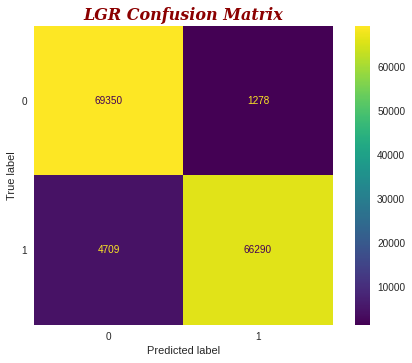

In [54]:
# Plotting the confusion matrix 
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkRed'}

plot_confusion_matrix(gs, X_test, y_test, values_format='d')
plt.title('LGR Confusion Matrix', fontdict=font1)
plt.grid(False)
plt.show()

In [55]:
# Model evaluation - Sensitivity, Specificity and Precision 
TN, FP, FN, TP = confusion_matrix(y_test, gs.predict(X_test)).flatten()
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

sensitivity = TP/(TP + FN)
specificity = TN/(TN + FP)
precision = TP/(TP + FP)
print("\nSensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)

True Negatives: 69350
False Positives: 1278
False Negatives: 4709
True Positives: 66290

Sensitivity: 0.9336751221848195
Specificity: 0.9819051934077137
Precision: 0.9810857210513853


From the results above, we can see that there are more false negatives than false positives. This cannot be a smart model because ignoring the probability of a transaction being fraud when there actually is one is very dangerous. It is a very serious data breach! So we need to lower the probability threshold in order to increase the true positive rate. 

In [56]:
# Model evaluation -AUC
# Calculate AUC for both training and testing subsets
# Only probabilities being in the positive class is needed for the calculation, that is the second column
training_lgr_AUC = roc_auc_score(y_train, gs.predict_proba(X_train)[:, 1]) 
testing_lgr_AUC = roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])

print("Training LGR AUC:", training_lgr_AUC)
print("Testing LGR AUC:", testing_lgr_AUC)

Training LGR AUC: 0.991875643286456
Testing LGR AUC: 0.9915914611772135


**3. Gradeint Boosting Classifier (GBC) Model**

In [ ]:
# Separate the transformed features matrix and target vector into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=3)

In [26]:
# Instantiate and fit the model
gbc = GradientBoostingClassifier(n_estimators=150)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
# Model evaluation - accuracy 
training_gbc_accuracy = gbc.score(X_train, y_train)
testing_gbc_accuracy = gbc.score(X_test, y_test)

print("Training GBC Accuracy:", training_gbc_accuracy)
print("Testing GBC Accuracy:", testing_gbc_accuracy)

Training GBC Accuracy: 0.9886885442678974
Testing GBC Accuracy: 0.9883426182860613


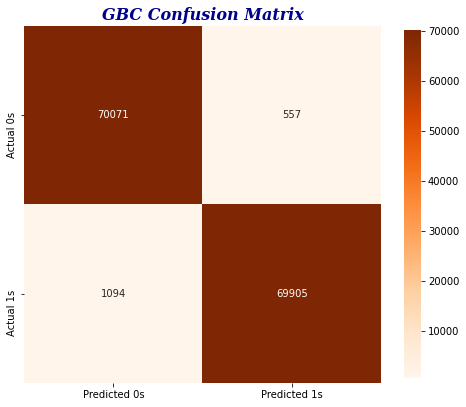

In [34]:
# Plotting the confusion matrix for Gradient Boosting 
fig, ax = plt.subplots(figsize=(8, 8))
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkBlue'}
font2 = {'weight': 'bold', 'size': 12}

sns.heatmap(confusion_matrix(y_test, gbc.predict(X_test)), 
            cmap='Oranges', 
            square=True,
            annot=True,
            fmt='d',
            cbar_kws={'shrink': 0.8},
            xticklabels=['Predicted 0s', 'Predicted 1s'],
            yticklabels=['Actual 0s', 'Actual 1s'])
ax.set_title('GBC Confusion Matrix', fontdict=font1)
plt.show()

In [28]:
# Model evaluation - Sensitivity, Specificity and Precision 
TN, FP, FN, TP = confusion_matrix(y_test, gbc.predict(X_test)).flatten()
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

sensitivity = TP/(TP + FN)
specificity = TN/(TN + FP)
precision = TP/(TP + FP)
print("\nSensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)

True Negatives: 70071
False Positives: 557
False Negatives: 1094
True Positives: 69905

Sensitivity: 0.9845913322722856
Specificity: 0.9921136093334089
Precision: 0.9920950299452187


In [30]:
# Model evaluation -AUC
# Calculate AUC for both training and testing subsets
# Only probabilities being in the positive class is needed for the calculation, that is the second column
training_gbc_AUC = roc_auc_score(y_train, gbc.predict_proba(X_train)[:, 1]) 
testing_gbc_AUC = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])

print("Training GBC AUC:", training_gbc_AUC)
print("Testing GBC AUC:", testing_gbc_AUC)

Training GBC AUC: 0.9995106512957558
Testing GBC AUC: 0.9994410722324646


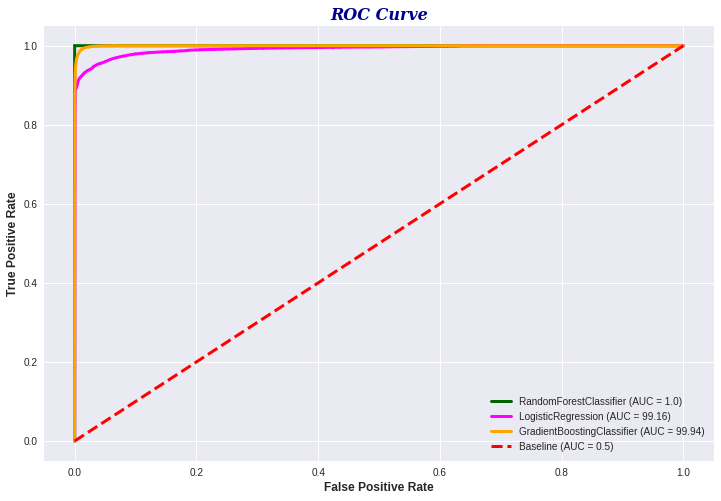

In [59]:
# Visualize the ROC curve for all the three models on the same graph to compare 
# their performances.
# http://www.navan.name/roc/
# https://stackoverflow.com/questions/61325314/how-to-change-plot-confusion-matrix-default-figure-size-in-sklearn-metrics-packa

plt.style.use('seaborn')
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkBlue'}
font2 = {'weight': 'bold', 'size': 12}

fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(rfc, X_test, y_test, color='darkgreen', linewidth=3, ax=ax, label='RandomForestClassifier (AUC = 1.0)')
plot_roc_curve(gs, X_test, y_test, color='magenta', linewidth=3, ax=ax, label='LogisticRegression (AUC = 99.16)')
plot_roc_curve(gbc, X_test, y_test, color='orange', linewidth=3, ax=ax, label='GradientBoostingClassifier (AUC = 99.94)')
plt.plot([0, 1], [0, 1], ls='--', color='red', linewidth=3, label='Baseline (AUC = 0.5)')
ax.legend(loc='lower right')
ax.set_title('ROC Curve', fontdict=font1)
ax.set_xlabel('False Positive Rate', fontdict=font2)
ax.set_ylabel('True Positive Rate', fontdict=font2)
plt.show()